## Import libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.isnull().sum()
# No missing values in the dataset

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [11]:
# Features
X = df.drop(['charges'], axis=1)
# Labels
y = df['charges'].values.reshape(-1,1)

## Data preprocessing

In [12]:
# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Encoding categorical labels & apply scaling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [14]:
# Categorical columns
columns_to_encode = ['sex', 'smoker','region']
# Numeric columns
numeric_cols = ['age','bmi','children']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_cols),
        ('encoder', OneHotEncoder(sparse_output=False), columns_to_encode)
    ],
    remainder='passthrough'
)

transformed_data_train = preprocessor.fit_transform(X_train)
transformed_data_test = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_['encoder']
ohe_feature_names = ohe.get_feature_names_out(columns_to_encode)
all_columns = numeric_cols + list(ohe_feature_names)

X_train = pd.DataFrame(transformed_data_train, columns=all_columns)
X_test = pd.DataFrame(transformed_data_test, columns=all_columns)

In [15]:
from sklearn.preprocessing import StandardScaler

# Scale y_train and y_test
y_scaler = StandardScaler()

# Fit on training targets only
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

## Train model

In [16]:
from sklearn.svm import SVR

In [19]:
svr_rbf = SVR(kernel = 'rbf', C=1, epsilon=0.1)

y_train = y_train.ravel()
y_test = y_test.ravel()
svr_rbf.fit(X_train, y_train)

y_train_pred = svr_rbf.predict(X_train)

In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    'kernel': ['rbf', 'poly', 'linear'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
}

grid = GridSearchCV(svr_rbf, params, cv=5)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}


## Evaluate model

In [20]:
from sklearn.metrics import r2_score

In [21]:
print(f'Score on train data: {svr_rbf.score(X_train, y_train)}')

Score on train data: 0.8529157649689196


In [22]:
y_test_pred = svr_rbf.predict(X_test)
print("Score on test data",r2_score(y_test, y_test_pred))

Score on test data 0.8571470302057604


## Plot

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

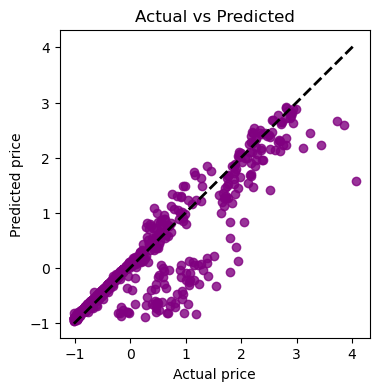

In [25]:
plt.figure(figsize=(4,4))
plt.scatter(y_train, y_train_pred, alpha=0.8, color='purple')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted')
plt.show()

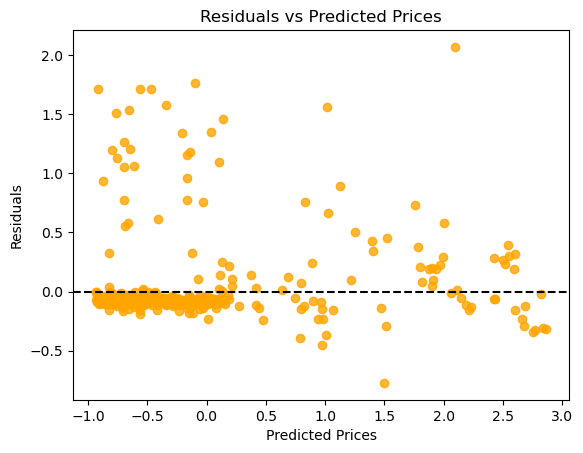

In [26]:
residuals = y_test - y_test_pred
plt.scatter(x=y_test_pred, y=residuals, alpha= 0.8, color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()

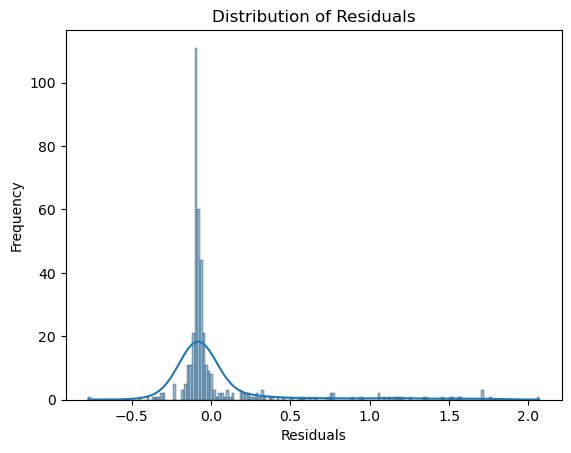

In [27]:
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

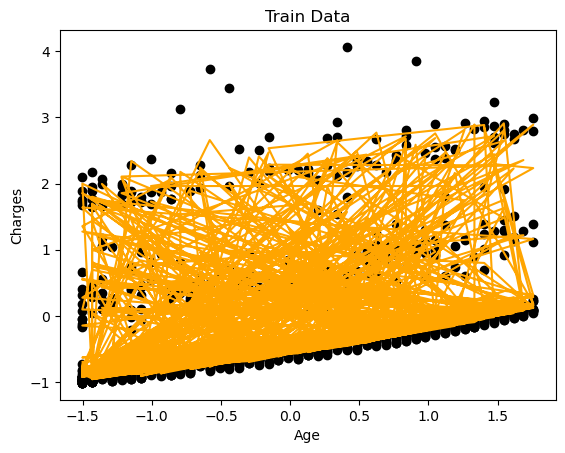

In [32]:
#### Visualization ####
plt.scatter(X_train['age'], y_train, color='black')
plt.plot(X_train['age'], y_train_pred, color = 'orange')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Train Data')
plt.show()

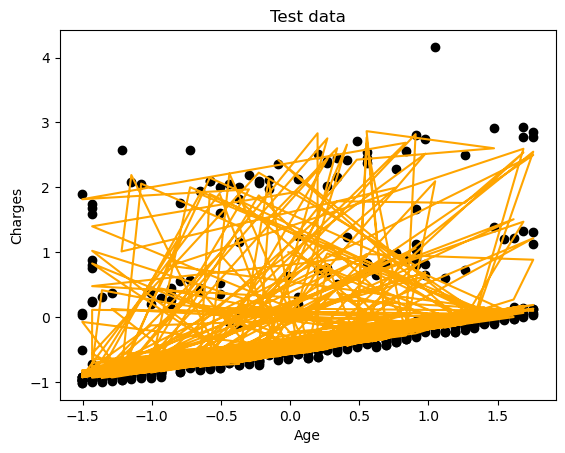

In [33]:
plt.scatter(X_test['age'], y_test, color='black')
plt.plot(X_test['age'], y_test_pred, color = 'orange')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Test data')
plt.show()